# Tryout of the Taylor expansion architecture
Let's test some stuff


In [4]:
import Polytion

Polytion.version()

version 1.0 30/03/2020


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import skimage
import tntorch as tn

Open the data example:

In [5]:
def remap(image, low, high):
    OldRange = (np.max(image) - np.min(image))  
    NewRange = (high - low)  
    return (((image - np.min(image)) * NewRange) / OldRange) + low

(512, 512)
(128, 128)


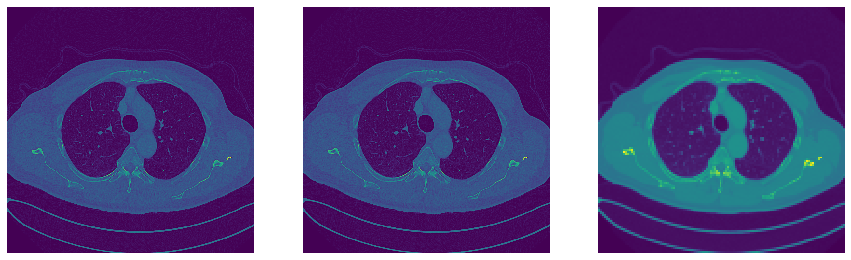

In [6]:
original = skimage.io.imread('../data?/Exploring CT/testim.png').astype(np.float)

# Remap to new range
truth = remap(original, 0, 255)
faked = skimage.transform.resize(truth, (truth.shape[0] / 4, truth.shape[1] / 4), anti_aliasing=True)

print(truth.shape)
print(faked.shape)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(original)
ax[0].axis("off")
ax[1].imshow(truth)
ax[1].axis("off")
ax[2].imshow(faked)
ax[2].axis("off");


# Import functions


In [7]:
def KronProd2D(P, Q):
    # Register dimensions.
    I, J = P.shape
    K, L = Q.shape
    
    # Adjust dimensions of P and Q to perform smart multiplication:
    # interweave the dimensions containing values and perform elementwise multiplication.
    P = P.view(I, 1, J, 1)
    Q = Q.view(1, K, 1, L)
    
    R = P * Q
    return R.view(I*K, J*L)

def KronProd(P, Q):
    # This should work for higher order tensors.
    # Register and check dimensions.
    pshape = P.shape
    qshape = Q.shape
    if P.dim() != Q.dim():
        raise ValueError('Matrices should be of the same order: P.dim() =' + str(P.dim()) + ' != Q.dim() = ' + str(Q.dim()))
    
    # Adjust dimensions of P and Q to perform smart multiplication:
    # interweave the dimensions containing values and perform elementwise multiplication.
    # Start with a list of ones and set dimensions as every even or uneven index.
    pindices = [1]*2*len(pshape)    
    pindices[::2] = pshape
    qindices = [1]*2*len(qshape)
    qindices[1::2] = qshape
        
    P = P.view(pindices)
    Q = Q.view(qindices)
    
    R = P * Q
    rshape = [p*q for p, q in zip(pshape,qshape)]
    return R.view(rshape)

def KathRaoProd(P, Q):
    # Register and check dimensions
    pshape = P.shape
    qshape = Q.shape
    J = pshape[-1]
    if J != qshape[-1]:
        raise ValueError('Matrices should have the same number of columns: ' + str(J) + ' != ' + str(qshape[-1]))
    
    # Make R an empty tensor
    rshape = [p*q for p, q in zip(pshape,qshape)]
    rshape[-1] = J
    R = torch.zeros(rshape)
    for j in range(J):
        R[:,j] = KronProd(P[:,j], Q[:,j])
                
    # Tried with slicing but did not seem to work:
    # column_indices = list(range(J)) or slice(0,J)
    # R[:, column_indices] = KronProd(P[:, column_indices], Q[:, column_indices])
    return R



In [8]:
def Permute_tensor(tensor, origin, axis, outputshape=None):
    # Perform the permutation of the tensor here, to be used in both Fold and Unfold.
    # For more explanation on this function see Unfold().
    
    dims = list(range(tensor.dim()))
    # For later use, we want to be able to map indices for a circular permutation
    if origin < 0: origin = dims[origin]
    if axis < 0: axis = dims[axis]
            
    dims.pop(origin)
    dims = dims[::-1]
    dims.insert(axis, origin)
    tensor = tensor.permute(*dims)
    
    if outputshape:
        tensor = tensor.reshape(outputshape)
    return tensor


def Unfold(tensor, mode):
    # Notation sets minimal mode to be 1, but we want to map that to zero. We also cannot mode_n unfold a matrix with n-1 modes.
    if mode > len(tensor.shape) or mode < 0:
        raise ValueError('Tensor has order ' + str(len(tensor.shape)) + ', cannot give mode ' + str(mode))
    
    # Register tensor shape and mode size
    order = tensor.dim()
    tshape = tensor.shape    
    I_n = tshape[mode]
    
    # To get the prescribed matrix in Kolda et al, we need to perform a permutation of the axes.
    # The selected mode needs to be viewed as the first, and all other dimensions should reverse their order.
    # It took a lot of experiments to get this right, the full functionality has been moved to Permute_tensor().    
    return Permute_tensor(tensor, mode, 0, (I_n, -1))


def Fold(unfolded_tensor, mode, desired_shape):
    print(desired_shape)
    # Perform the same entry safety controls
    if mode > len(desired_shape) or mode < 0:
        raise ValueError('Folded tensor has order ' + str(len(desired_shape)) + ', cannot give mode ' + str(mode))
    
    # Before calling Permute_tensor(), we need to reshape the unfolded tensor back to its' desired order.
    # This does not yield the desired tensor but takes into account the coming permutation.
    shape = list(desired_shape)
    axis = shape.pop(mode)
    shape = shape[::-1]
    shape.insert(0, axis)
    tensor = unfolded_tensor.reshape(desired_shape)
    
    # return Permute_tensor(tensor, 0, mode, desired_shape)
    # Exactly my point before, we have accounted for the exact inverse transformation without the need for a reshape.
    # Both return statements yield the same result.
    return Permute_tensor(tensor, 0, mode)


In [9]:
def nmodemult(tensor, matrix_or_vector, mode):
    new_shape = list(tensor.shape)
    new_shape.pop(mode)
    print(new_shape)
    unf = Unfold(tensor, mode)
    print(unf.shape)
    print(matrix_or_vector.shape)
    res = matrix_or_vector @ unf
    return Fold(res, mode, tshape)


In [10]:
import tensorly as tl
tl.set_backend('pytorch')

In [11]:
W = torch.rand(5,5)
z = torch.ones(5,1)
m = torch.ones(1,5)
#print((W@z).reshape(5,5,5).shape)
#nmodemult(W, z, 1)

result = tl.tenalg.mode_dot(W, m, 0)
print(result.shape)

product = torch.matmul(W,z)
print(product.shape)


torch.Size([1, 5])
torch.Size([5, 1])


In [12]:
W = torch.rand(3,3)
print(W)
print(W[:,0])

tensor([[0.4562, 0.9775, 0.4340],
        [0.3227, 0.9238, 0.1453],
        [0.6647, 0.6625, 0.1180]])
tensor([0.4562, 0.3227, 0.6647])


In [13]:
(((512*512) + (512*512)**2)*8)/10**9

549.75791104

# Get the network!
Make a layer that represents the polynomial approximation of the input

In [14]:
N = 2
im_w, im_h = truth.shape
print(im_w, im_h)
print(((im_w*im_h*8))/(10**9))

512 512
0.002097152


How do we actually compute the output without recreating the whole matrix? Start from the factor matrices, where the outer product $\circ$ gives the elements of the matrix:
\begin{align*}
\boldsymbol{\mathcal{X}} &= \sum_{r=1}^{R} \mathbf{a}_{r} \circ \mathbf{b}_{r} \circ \mathbf{c}_{r} \\
\mathcal{x}_{i j k} &\approx \sum_{r=1}^{R} a_{i r} b_{j r} c_{k r} \text { for } i=1, \ldots, I, j=1, \ldots, J, k=1, \ldots, K \\
&\approx \sum_{r=1}^{R} \prod_{m = 1}^{o} a^{[m]}_{i_m, \: r} \: \text{ with } o = order(\boldsymbol{\mathcal{X}})
\end{align*}


Splitting up the PolyGAN equation
\begin{align*}
\boldsymbol{f(\boldsymbol{z})} &= \boldsymbol{\beta} 
+ \boldsymbol{W}^{[1]} \boldsymbol{z}
+ \boldsymbol{z}^{T} \boldsymbol{W}^{[2]} \boldsymbol{z} 
+ \boldsymbol{\mathcal{W}}^{[3]} \times_{1} \boldsymbol{z} \times_{2} \boldsymbol{z} \times_{3} \boldsymbol{z} 
+ \cdots 
+ \boldsymbol{\mathcal{W}}^{[N]} \prod_{n=1}^{N} \times_{n} \boldsymbol{z}\\
&= \boldsymbol{\beta} + \boldsymbol{W}^{[1]} \boldsymbol{z}
+ \boldsymbol{z}^{T} \boldsymbol{W}^{[2]} \boldsymbol{z} 
+ \sum_{n=3}^{N}\left(\boldsymbol{\mathcal{W}}^{[n]} \prod_{j=1}^{n} \times_{j} z\right)
\end{align*}


In polyclassification, we have for $\mathcal{A} \in \mathbb{R}^{n_{1} \times n_{2} \times \cdots \times n_{d}}$
\begin{align*}
f & = \mathcal{A} \times_{1}\left(\mathbf{v}^{(1)}\right)^{\top} \times_{2}\left(\mathbf{v}^{(2)}\right)^{\top} \times_{3} \cdots \times_{d}\left(\mathbf{v}^{(d)}\right)^{\top} 
= \mathcal{A} \prod_{k = 1}^{d} \times_{k} \mathbf{v}^{(k)} \\
& = \prod_{k=1}^{d} \sum_{i_{k}=1}^{n_{k}} v_{i_{k}}^{(k)} \mathcal{G}_{k}\left(i_{k}\right)
\end{align*}

Using $\boldsymbol{\mathcal{W}}^{[n]} \in \mathbb{R}^{d \times d \times \dots \times d \:=\: (n + 1) \cdot d}$ we can write 
\begin{align*}
\boldsymbol{\mathcal{W}}^{[n]} \prod_{k=1}^{n} \times_{k} z = \prod_{k=1}^{n} \sum_{r = 1}^{R} \left( \sum_{i_k=1}^{d} z_{i_k} a^{[k]}_{i_k, \:r}\right)
\end{align*}

For $\boldsymbol{{W}}^{[1]} \in \mathbb{R}^{d \times d = 2\cdot d}$, with $w^{[1]}_{i,j} = \sum_{r=1}^{3} a_{i r} b_{j r}$ we would get:
\begin{align*}
\prod_{k=1}^{1} \sum_{r = 1}^{3} \left( \sum_{i_k=1}^{d} z_{i_k} a^{[k]}_{i_k, \:r}\right) 
= \sum_{i_k=1}^{d} z_{i}
\end{align*}


Try it again...
\begin{align*}
\boldsymbol{f(\boldsymbol{z})} &= \boldsymbol{\beta} 
+ \boldsymbol{W}^{[2]} \boldsymbol{z}
+ \boldsymbol{z}^{T} \boldsymbol{W}^{[3]} \boldsymbol{z} 
+ \boldsymbol{\mathcal{W}}^{[4]} \times_{1} \boldsymbol{z} \times_{2} \boldsymbol{z} \times_{3} \boldsymbol{z} 
+ \cdots 
+ \boldsymbol{\mathcal{W}}^{[N+1]} \prod_{n=1}^{N} \times_{n} \boldsymbol{z}
\end{align*}


\begin{align*}
\mathcal{W}^{[d]}_{i_{1} i_{2} \cdots i_{d}} = \sum_{r=1}^{R} a_{i_{1}, r} b_{i_{2}, r} \cdots d_{i_{d}, r}
= \sum_{r=1}^{R} \prod_{k = 1}^{d} a^{[k]}_{i_{k}, r}
\end{align*}


\begin{align*}
\boldsymbol{\mathcal{W}}^{[n]} \times_{1}\boldsymbol{z} \times_{2}\boldsymbol{z} \times_{3} \cdots \times_{n-1}\boldsymbol{z} = \boldsymbol{\mathcal{W}}^{[n]} \prod_{k = 1}^{n-1} \times_{k} \boldsymbol{z}
\end{align*}

\begin{align*}
\boldsymbol{\mathcal{W}}^{[n]} \times_{1}\boldsymbol{z} \times_{2}\boldsymbol{z} \times_{3} \cdots \times_{n-1}\boldsymbol{z} 
= \boldsymbol{\mathcal{W}}^{[n]} \prod_{k = 1}^{n-1} \times_{k} \boldsymbol{z} 
= \prod_{k = 1}^{n-1} \sum_{i_{k}}^{d} z_{i_k} \left( \sum_{r=1}^{R} a^{[k]}_{i_k, r} \right)
\end{align*}

\begin{align*}
\boldsymbol{\mathcal{W}}^{[n]} \prod_{k = 1}^{n-1} \times_{k} \boldsymbol{z} 
= \left(\sum_{r=1}^{R} \prod_{k = 1}^{n} a^{[k]}_{i_{k}, r} \right) \prod_{j = 1}^{n-1} \sum_{i = 1}^{d} 
\end{align*}

For a single product:

\begin{align*}
\left(\boldsymbol{X} \times_{n} \mathbf{v}\right)_{i_{1} \cdots i_{n-1} i_{n+1} \cdots i_{N}}=\sum_{i_{n}=1}^{I_{n}} x_{i_{1} i_{2} \cdots i_{N}} v_{i_{n}}
\end{align*}

\begin{align*}
\left(\boldsymbol{\mathcal{W}} \times_{n} \boldsymbol{z}\right)_{i_{1} \cdots i_{n-1} i_{n+1} \cdots i_{N}}
= \sum_{i_{n}=1}^{d} w_{i_{1} i_{2} \cdots i_{N}} z_{i_{n}}
\end{align*}

In [69]:
class PolyLayer(torch.nn.Module):
    def __init__(self, N, im_w, im_h):
        super(PolyLayer, self).__init__()
        
        self.d = im_w * im_h
        # N = order of the polynomial
        # d = length of the flattened input
        
        # Currently arvitrary rank choice
        self.rank = 3
        self.shapes = []
        
        self.b = torch.nn.Parameter(torch.zeros((self.d)).normal_(0, np.sqrt(2)))
        self.W = torch.nn.ParameterList()
        
        # 0th order: bias [d], 1st order: weight [d, d], 2nd order: weight [d, d, d]
        for n in range(1, N + 1):
            tshape = [self.d]*(n + 1)
            print("Order", n, ":", len(tshape), "D tensor")
            self.shapes.append(tshape)
                        
            # Here we allocate all the factor matrices (using CP):
            for o in range(n + 1):
                # We need one factor matrix per dimension of the weight matrix of that order.
                # So 3rd order [d, d, d] has 3 factor matrices of shape [d, rank]
                factor = torch.zeros((self.d, self.rank)).normal_(0, np.sqrt(2))
                self.W.append(torch.nn.Parameter(factor))   
        
        print("W has", len(self.W), "elements")
                
    def polyGAN(self, data):
        #return self.b + self.W[0]*data + data.T*...
        
        summation = self.b
        Wcounter = 0
        for n in range(1, N + 1):
            # n = 1: first  order so 2D matrix with 2 fm's
            # n = 2: second order so 3D tensor with 3 fm's
            allprod = torch.ones(self.d)
            for k in range(n + 1):
                vecprod = 0
                print("n =", n, ", k =", k)
                print("len(self.W) =", len(self.W))
                print(n + (k))
                print(Wcounter)
                for r in range(self.rank):
                    fm_col = self.W[Wcounter][:,r]
                    vecprod += data * fm_col
                Wcounter += 1
                allprod *= vecprod
            
        return summation
        
    def forward(self, x):
        return self.polyGAN(x)

In [72]:
# define network
class PolytionNet(torch.nn.Module):
    def __init__(self, N, im_w, im_h):
        super(PolytionNet, self).__init__()
        
        self.im_w, self.im_h = im_w, im_h
        self.PG = PolyLayer(N, im_w, im_h)
    
    def forward(self, x): 
        # Find bilinear version of this:
        x = skimage.transform.resize(x, (self.im_w, self.im_h), order=2, anti_aliasing=True)
        x = torch.tensor(x) # make tensor
        x = x.reshape(self.im_w*self.im_h) # flatten to the 1D equivalent vector
        x = x.float() # no need for the very high precision
        
        x = self.PG(x)
        return x.reshape(self.im_w, self.im_h)

net = PolytionNet(N, im_w, im_h)

Order 1 : 2 D tensor
Order 2 : 3 D tensor
W has 5 elements


In [73]:
net = net.float() 
net(faked)

n = 1 , k = 0
len(self.W) = 5
1
0
n = 1 , k = 1
len(self.W) = 5
2
1
n = 2 , k = 0
len(self.W) = 5
2
2
n = 2 , k = 1
len(self.W) = 5
3
3
n = 2 , k = 2
len(self.W) = 5
4
4


tensor([[-0.2866,  0.0523, -3.6029,  ...,  0.2044, -3.3021,  1.9261],
        [ 0.3848, -0.2637, -1.0228,  ...,  1.5072, -0.5340, -0.6229],
        [-0.2947, -3.1850,  1.3088,  ..., -2.1277, -2.6868,  1.5488],
        ...,
        [ 0.7782, -0.0733,  0.1757,  ...,  0.1836, -1.4417,  1.3464],
        [-0.7866, -2.2523, -1.4539,  ..., -0.2484,  0.6607, -0.0149],
        [ 0.8849,  2.0709, -0.1233,  ...,  1.2649,  0.6838,  0.0149]],
       grad_fn=<ViewBackward>)

n = 1 , k = 0
len(self.W) = 5
1
0
n = 1 , k = 1
len(self.W) = 5
2
1
n = 2 , k = 0
len(self.W) = 5
2
2
n = 2 , k = 1
len(self.W) = 5
3
3
n = 2 , k = 2
len(self.W) = 5
4
4


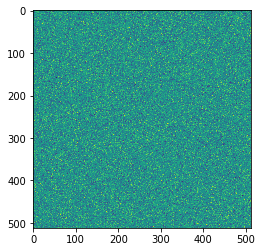

In [77]:
test = net(faked)
plt.imshow(test.detach().numpy())


In [115]:
# Time the learning process:
import time
from tqdm import tqdm

def closure():
    optm_start = time.time()
    optimizer.zero_grad()
    optm_timer.append(time.time() - optm_start)
    
    crit_start = time.time()
    loss = criterion(pred, torch.tensor(truth.flatten()).float())
    crit_timer.append(time.time() - crit_start)
    
    loss_start = time.time()
    loss.backward()
    loss_timer.append(time.time() - loss_start)
    
    return loss

criterion = torch.nn.MSELoss(reduction='sum')
#See the example here: https://github.com/fehiepsi/rethinking-pyro/blob/master/notebooks/rethinking.py#L54
optimizer = torch.optim.LBFGS(net.parameters(), lr=1e-3)
net.train()
net = net.float() 

loops = 10
pred_timer = []
crit_timer = []
optm_timer = []
loss_timer = []
step_timer = []

start = time.time()

for t in tqdm(range(loops)):
    # Forward pass: Compute predicted y by passing x to the model
    pred_start = time.time()
    pred = net(faked)
    pred_timer.append(time.time() - pred_start)
    
    # Zero gradients, perform a backward pass, and update the weights.
    step_start = time.time()
    optimizer.step(closure)
    step_timer.append(time.time() - step_start)

total_elapsed = time.time() - start
elapsed_per_loop = float(total_elapsed/loops)


100%|██████████| 10/10 [02:56<00:00, 22.65s/it]


In [116]:
mean = lambda x : sum(x)/len(x)

print("Total elapsed time =", total_elapsed, "s, with", elapsed_per_loop, "s per loop")
print("pred_timer =", mean(pred_timer), "s on average")
print("crit_timer =", mean(crit_timer), "s on average")
print("optm_timer =", mean(optm_timer), "s on average")
print("loss_timer =", mean(loss_timer), "s on average")
print("step_timer =", mean(step_timer), "s on average")


Total elapsed time = 176.95096898078918 s, with 17.69509689807892 s per loop
pred_timer = 0.0248809814453125 s on average
crit_timer = 0.0018077250365372542 s on average
optm_timer = 0.00014944128937773653 s on average
loss_timer = 0.00082376894060072 s on average
step_timer = 17.669066739082336 s on average


In [120]:
# Time the learning process:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

pred_timer = []
crit_timer = []
optm_timer = []
loss_timer = []
step_timer = []

start = time.time()

for t in tqdm(range(loops)):
    # Forward pass: Compute predicted y by passing x to the model
    pred_start = time.time()
    pred = net(faked)
    pred_timer.append(time.time() - pred_start)
    
    crit_start = time.time()
    loss = criterion(pred, torch.tensor(truth.flatten()).float())
    crit_timer.append(time.time() - crit_start)
    
    optm_start = time.time()
    optimizer.zero_grad()
    optm_timer.append(time.time() - optm_start)
    
    loss_start = time.time()
    loss.backward()
    loss_timer.append(time.time() - loss_start)
    
    step_start = time.time()
    optimizer.step()
    step_timer.append(time.time() - step_start)

total_elapsed = time.time() - start
elapsed_per_loop = float(total_elapsed/loops)


100%|██████████| 10/10 [00:00<00:00, 35.76it/s]


In [121]:
print("Total elapsed time =", total_elapsed, "s, with", elapsed_per_loop, "s per loop")
print("pred_timer =", mean(pred_timer), "s on average")
print("crit_timer =", mean(crit_timer), "s on average")
print("optm_timer =", mean(optm_timer), "s on average")
print("loss_timer =", mean(loss_timer), "s on average")
print("step_timer =", mean(step_timer), "s on average")


Total elapsed time = 0.28276896476745605 s, with 0.028276896476745604 s per loop
pred_timer = 0.024054193496704103 s on average
crit_timer = 0.001506972312927246 s on average
optm_timer = 0.00013339519500732422 s on average
loss_timer = 0.000652313232421875 s on average
step_timer = 0.001376938819885254 s on average
